Mikołaj Chomanski

Władysław Młynik

In [10]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image

In [2]:
device = torch.device("cuda")
device

device(type='cuda')

# Loada Data

In [22]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.2),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform_more_augmentation = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.2),
     transforms.RandomPerspective(distortion_scale=0.3, p=0.05),
     transforms.ColorJitter(brightness=.5),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root ="data/train/", transform=train_transform)

total_size = len(dataset)
train_size = int(0.95 * total_size)
val_size = total_size - train_size

# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 128

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [17]:
len(dataset.classes)
len(dataset)

88011

In [23]:
def get_accuracy(model: nn.Module, data_loader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

# Model

Nasz najlepszy model to ten drugi (z 4 warstwami konwolucyjnymi), ale ten pierwszy uzyskiwał również dobre wyniki

In [32]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout2 = nn.Dropout2d(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=2)
        self.batch2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout3 = nn.Dropout2d(0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=2, padding=2)
        self.batch3 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout4 = nn.Dropout2d(0.1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(8192, 1028)
        self.dropout4 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1028, 600)
        self.dropout5 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(600, 50)

    def forward(self, x):
        x = self.pool2(F.leaky_relu(self.batch1(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(F.leaky_relu(self.batch2(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool4(F.leaky_relu(self.batch3(self.conv4(x))))
        x = self.dropout4(x)


        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)
        return x



net = ImageClassifier().to(device)
net

ImageClassifier(
  (conv2): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (batch3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1028, bias=

In [39]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout2 = nn.Dropout2d(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout3 = nn.Dropout2d(0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.batch3 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout4 = nn.Dropout2d(0.1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.batch4 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout5 = nn.Dropout2d(0.1)


        self.fc1 = nn.Linear(2048, 512)
        self.dropout4 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 128)
        self.dropout5 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 50)

    def forward(self, x):
        x = self.pool2(F.gelu(self.batch1(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(F.gelu(self.batch2(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool4(F.gelu(self.batch3(self.conv4(x))))
        x = self.dropout4(x)
        x = F.gelu(self.batch4(self.conv5(x)))
        x = self.dropout5(x)


        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)
        return x



net = ImageClassifier().to(device)
net

ImageClassifier(
  (conv2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.1, inplace=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  

# Training

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=0.000001)

In [27]:
epochs = 40

test_los_per_epoch = []
train_loss_per_epoch = []
accuracy_per_epoch = []

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    correct = 0.0
    total = 0.0
    val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for j, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'[{epoch+1}/{epochs}] train loss: {running_loss / i} val loss: {val_loss / j} accuracy: {100 * correct / total}%')

    accuracy_per_epoch.append(100 * correct / total)
    test_los_per_epoch.append(val_loss / j)
    train_loss_per_epoch.append(running_loss / i)

print('Finished Training')

[1/10] train loss: 1.2473343044838898 val loss: 0.7471104439567117 accuracy: 79.86821177005226%
[2/10] train loss: 1.237676854885738 val loss: 0.7375824661815867 accuracy: 79.8227675528289%
[3/10] train loss: 1.2301878182482755 val loss: 0.7602046184680041 accuracy: 79.02749375142014%
[4/10] train loss: 1.2222264402675775 val loss: 0.7609711955575382 accuracy: 78.77755055669166%


KeyboardInterrupt: 

# Data Analisis

In [41]:
print(f'Accuracy of the network on the train images: {get_accuracy(net, trainloader)*100}')

Accuracy of the network on the train images: 80.31335964597535


Text(0.5, 1.0, 'Accuracy During Training on Validation Set')

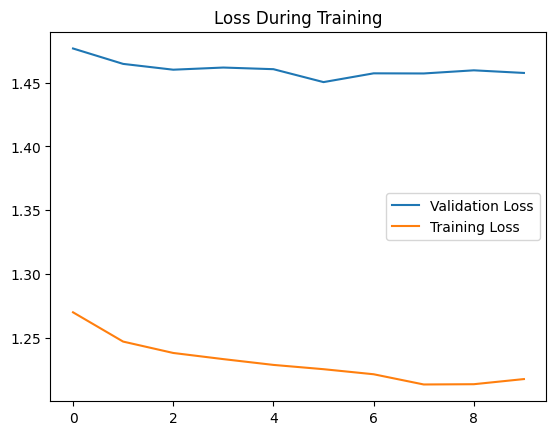

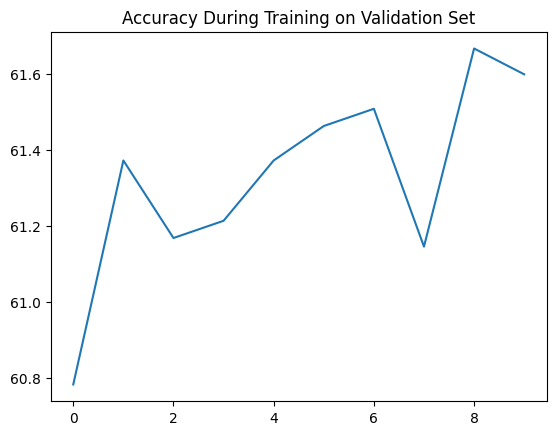

In [67]:
import matplotlib.pyplot as plt

plt.plot(test_los_per_epoch, label='Validation Loss')
plt.plot(train_loss_per_epoch, label='Training Loss')
plt.legend()
plt.title('Loss During Training')
plt.figure()
plt.plot(accuracy_per_epoch, label='Accuracy')
plt.title('Accuracy During Training on Validation Set')

In [68]:
torch.save(net,"train_81.17_test_61._more_batches.model")

# Prediction

In [40]:
net = torch.load("best_model_Chomanski_Młynik.model")

In [43]:
class CustomImageDataset(torchvision.datasets.DatasetFolder):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for root, _, files in os.walk(self.root):
            for file in files:
                if file.endswith('.JPEG'):
                    sample_path = os.path.join(root, file)
                    samples.append((sample_path, 0))  # Dummy label, as it's not used
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        sample = Image.open(path).convert('RGB')
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [44]:
batch_size = 128
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_dataset = CustomImageDataset(root="data/test_all/", transform=test_transform)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions = []
net.eval()
with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
file_names = [os.path.basename(test_dataset.samples[i][0]) for i in range(len(test_dataset))]
df = pd.DataFrame({'filename': file_names, 'predicted_class': predictions})
df.to_csv('predictions_best.csv', index=False, header=False)